## Урок 4.
# Способы улучшения полученной модели.

**План занятия**

* [Теоретическая часть](#theory)
    * [Переобучение и способы борьбы с ним](#overfitting)
    * [Регуляризация](#regularization)
* [Практическая часть](#practice)
    * [Загрузка подготовленных датасетов](#data_loading)
    * [Модель, полученная на предыдущем уроке](#model_from_prev_lesson)
    * [Снижение степени переобучения](#lowering_overfitting)
    * [Подбор оптимального размера выборки, кривая обучения](#learning_curve)
    * [Выбор порога вероятности для определения класса](#threshold_calibration)
    * [Важность признаков](#feature_importances)  
    * [Финальная модель](#final_model)
    * [Сохранение финальной модели](#final_model_saving)

## <center>Теоретическая часть<a class="anchor" id="theory"></a><center>

### Переобучение и способы борьбы с ним<a class="anchor" id="overfitting"></a>

**Переобучение**

Нежелательное явление, возникающее при решении задач обучения по прецедентам, когда вероятность ошибки обученного алгоритма на объектах тестовой выборки оказывается существенно выше, чем средняя ошибка на обучающей выборке. Переобучение возникает при использовании избыточно сложных моделей.

<img src="overfitting.svg" alt="Drawing" style="width: 500px;">

**Способы борьбы с переобучением**

1. Обнаружить переобучение:
    * отложенная выборка
    * кросс-валидация
    * меры сложности модели
2. Взять больше данных
3. Выбрать более простую медель
4. Регуляризация

### Регуляризация<a class="anchor" id="regularization"></a>

Регуляризация - метод борьбы с переобучением, с помощью добавления некоторого штрафа за сложность модели.

<img src="bias.png" alt="Drawing" style="width: 500px;">

**L1-регуляризация** (lasso, регуляризация через манхэттенское расстояние)

$\large L_1 = \sum_{i=1} (y_i - \widehat{y_i})^2 + \lambda\sum_{j=1} |w_j|$

**L2-регуляризация** (ridge, регуляризация Тихонова)

$\large L_2 = \sum_{i=1} (y_i - \widehat{y_i})^2 + \lambda\sum_{j=1} w_j^2$

## <center>Практическая часть<a class="anchor" id="practice"></a><center>

**Подключение библиотек и скриптов**

In [0]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [0]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [0]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [0]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Пути к директориям и файлам**

In [0]:
# input
TRAIN_FULL_PATH = '../training_project_train_full.csv'
TRAIN_PART_PATH = '../training_project_train_part_b.csv'
TEST_PART_PATH = '../training_project_test_part.csv'

# output
MODEL_FILE_PATH = '../model.pkl'

### Загрузка подготовленных датасетов<a class="anchor" id="data_loading"></a>

**Загрузка данных**

In [0]:
df = pd.read_csv(TRAIN_FULL_PATH)
df_train = pd.read_csv(TRAIN_PART_PATH)
df_test = pd.read_csv(TEST_PART_PATH)

**Выделение признакового описания и целевой переменной**

In [0]:
TARGET_NAME = 'NEXT_MONTH_DEFAULT'
NUM_FEATURE_NAMES = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

CAT_FEATURE_NAMES = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [0]:
X = df.drop(columns=CAT_FEATURE_NAMES + ['ID', TARGET_NAME])
y = df[TARGET_NAME]

X_train = df_train.drop(columns=TARGET_NAME)
y_train = df_train[TARGET_NAME]

X_test = df_test.drop(columns=TARGET_NAME)
y_test = df_test[TARGET_NAME]

### Модель, полученная на предыдущем уроке<a class="anchor" id="model_from_prev_lesson"></a>

In [0]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.85      0.79      5500
           1       0.78      0.64      0.71      4500

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.76      0.75     10000

TEST

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2305
           1       0.51      0.57      0.54       695

   micro avg       0.77      0.77      0.77      3000
   macro avg       0.69      0.70      0.69      3000
weighted avg       0.78      0.77      0.78      3000

CONFUSION MATRIX

col_0                0.0  1.0
NEXT_MONTH_DEFAULT           
0                   1919  386
1                    296  399


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [0]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.85      0.78      5500
           1       0.77      0.61      0.68      4500

   micro avg       0.74      0.74      0.74     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.74      0.74     10000

TEST

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2305
           1       0.51      0.57      0.54       695

   micro avg       0.77      0.77      0.77      3000
   macro avg       0.69      0.70      0.69      3000
weighted avg       0.78      0.77      0.78      3000

CONFUSION MATRIX

col_0                0.0  1.0
NEXT_MONTH_DEFAULT           
0                   1921  384
1                    297  398


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [0]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)

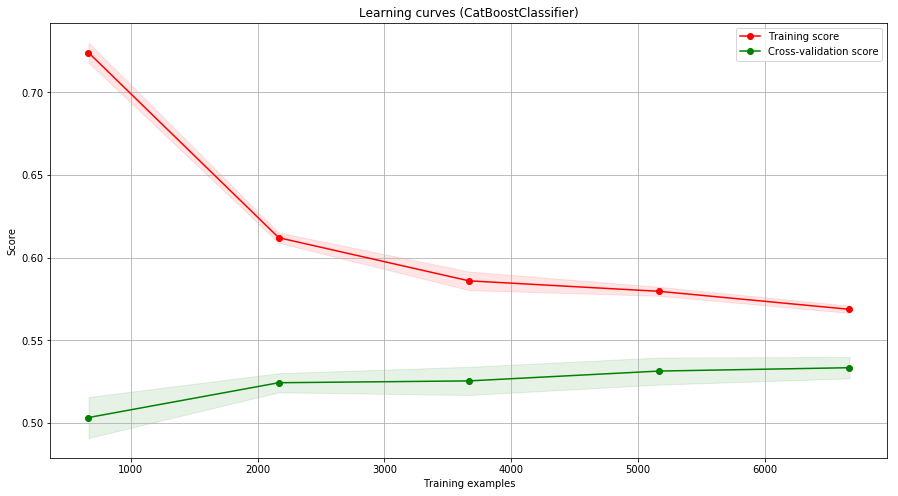

In [0]:
show_learning_curve_plot(final_model, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

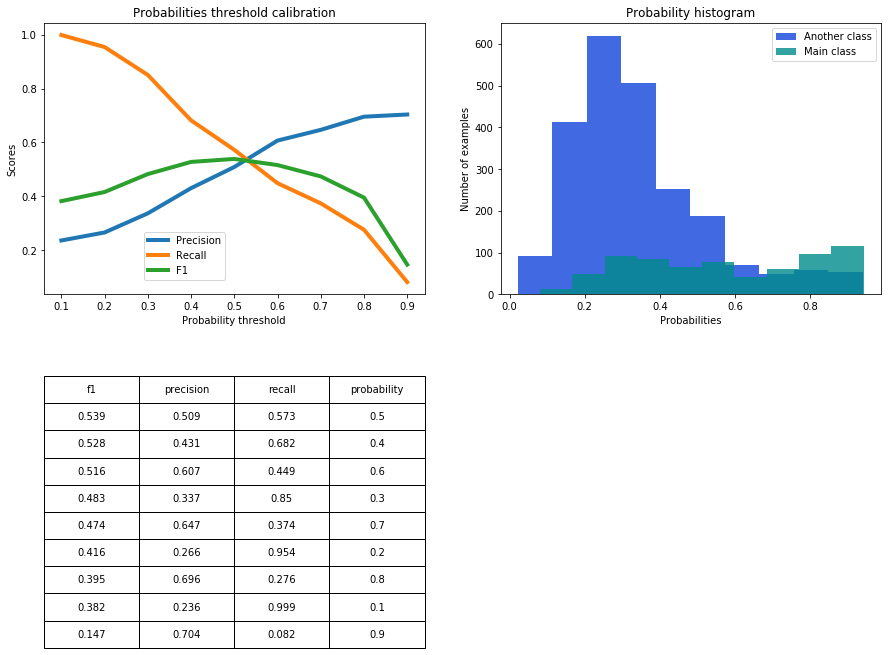

In [0]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

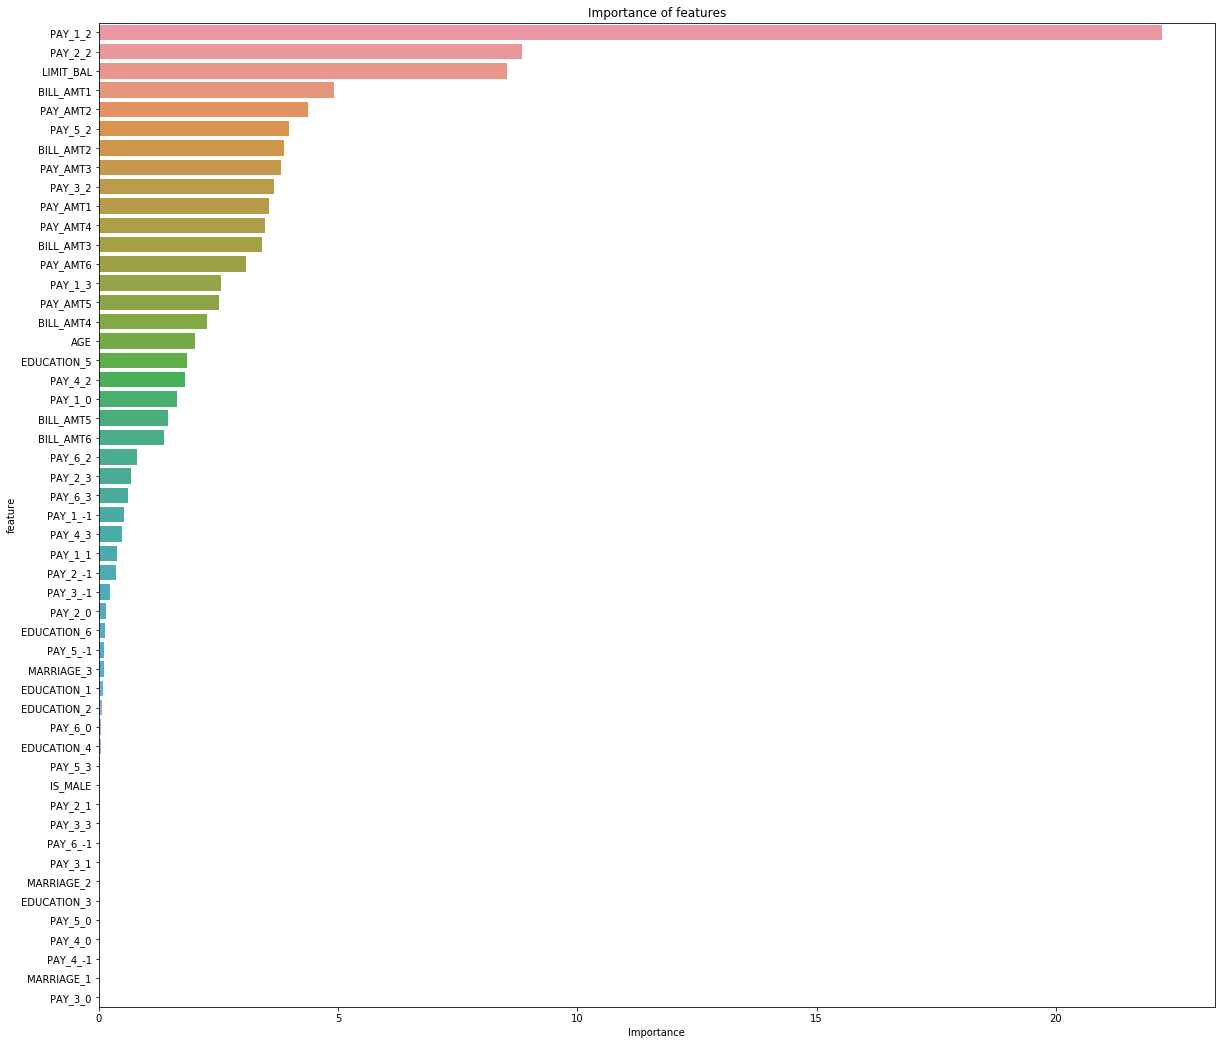

In [0]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [0]:
important_features_top

['PAY_1_2',
 'PAY_2_2',
 'LIMIT_BAL',
 'BILL_AMT1',
 'PAY_AMT2',
 'PAY_5_2',
 'BILL_AMT2',
 'PAY_AMT3',
 'PAY_3_2',
 'PAY_AMT1',
 'PAY_AMT4',
 'BILL_AMT3',
 'PAY_AMT6',
 'PAY_1_3',
 'PAY_AMT5']

### Финальная модель<a class="anchor" id="final_model"></a>

In [0]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3, l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.84      0.78      5500
           1       0.76      0.61      0.67      4500

   micro avg       0.74      0.74      0.74     10000
   macro avg       0.74      0.72      0.73     10000
weighted avg       0.74      0.74      0.73     10000

TEST

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      2305
           1       0.50      0.57      0.53       695

   micro avg       0.77      0.77      0.77      3000
   macro avg       0.68      0.70      0.69      3000
weighted avg       0.78      0.77      0.77      3000

CONFUSION MATRIX

col_0                0.0  1.0
NEXT_MONTH_DEFAULT           
0                   1907  398
1                    300  395


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [0]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)